In [2]:
import os
import sys
import pandas as pd
import numpy as np
import time
from collections import defaultdict
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from utils.dataset import *
from size_gru import GRU, SizeToHidden
from size_vae import SizeEncoder, SizeDecoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/root/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir(sys.path[0])
pairs = 1000
pairdata, freqpairs, n_size, n_interval = get_univ_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)
size_cdf = pd.read_csv('data/univ/size_cdf.csv')

In [5]:
decoder = torch.load('model/final/decoder.pth')
gru = torch.load('model/final/gru.pth')
s2h = torch.load('model/final/s2h.pth')
vae_latent_dim = decoder.decoder[0][0].in_features
gru_hidden_size = gru.gru.hidden_size

In [6]:
def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

def get_mean_interval(mean_size, load):
    return 1/(100E9*load/8./mean_size) * 1E9

def sample_size(cdf, index):
    if index == 0:
        return cdf.iloc[0]['size']
    return cdf.iloc[index - 1]['size'] + np.random.rand() * (cdf.iloc[index]['size'] - cdf.iloc[index - 1]['size'])

all_size = []
for i in range(pairs):
    all_size.extend(list(pairdata[freqpairs[i]]['size_index'].values))
values, counts = np.unique(all_size, return_counts=True)
all_size = np.zeros(n_size, dtype=np.float64)
all_size[values] = counts
all_size /= all_size.sum()

def gen_real(seed, pair, load, n):
    np.random.seed(seed)
    size_index = pairdata[freqpairs[pair]]['size_index'].values
    sizes = []
    while len(sizes) < n:
        sizes += list(size_index)
    sizes = np.array(sizes)[:n]
    sizes = np.array([sample_size(size_cdf, i) for i in sizes])
    mean_size = int(get_mean_interval(np.mean(sizes), load))
    intervals = np.random.exponential(mean_size, n).astype(int)
    return sizes, intervals


def gen_common(seed, pair, load, n):
    np.random.seed(seed)
    sizes = []
    while len(sizes) < n:
        sizes.append(np.random.choice(n_size, p=all_size))
    sizes = np.array([sample_size(size_cdf, i) for i in sizes])
    mean_size = int(get_mean_interval(np.mean(sizes), load))
    intervals = np.random.exponential(mean_size, n).astype(int)
    return sizes, intervals


def sample_batch(size_data, seq_length, start_size, batch_size):
    gru.eval() 
    s2h.eval()
    softmax = nn.Softmax(dim=2).to(device)
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        size = start_size
        output_seq = [size]
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([size])).to(device)
            input = input.float().permute(1,0,2)
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = [np.random.choice(n_size, p=p_size[i]) for i in range(batch_size)]
            output_seq.append(size)
        return output_seq


def gen_encore(load, n):
    batch_size = 1000
    torch.manual_seed(0)
    z = torch.randn((batch_size, vae_latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy().astype(np.float64)
    size[size < 1e-3] = 0
    size /= size.sum(axis=1).reshape(-1, 1)
    start_size = [np.random.choice(n_size, p=size[i]) for i in range(batch_size)]
    size_index = []
    while len(size_index) < n:
        output_seq = sample_batch(size, 16, start_size, batch_size)
        size_index += output_seq[1:]
        start_size = output_seq[-1]
    size_index = np.array(size_index).T
    sizes, intervals = [], []
    for i in tqdm(range(batch_size)):
        sizes.append([int(sample_size(size_cdf, j)) for j in size_index[i]])
        mean_size = int(get_mean_interval(np.mean(sizes[i]), load))
        intervals.append(np.random.exponential(mean_size, n).astype(int))
    return sizes, intervals

In [7]:
class Flow:
	def __init__(self, src, dst, size, t):
		self.src, self.dst, self.size, self.t = src, dst, size, t
	def __str__(self):
		return "%d %d 3 100 %d %.9f"%(self.src, self.dst, self.size, self.t)

def gen_traces(dir, func, load, n):
    for trace in tqdm(range(1000)):
        np.random.seed(trace)
        src = 1
        dst = 0
        sizes, intervals = func(trace, trace, load, n)
        base_t = 2e9
        f_list = []
        t = base_t
        for size, interval in zip(sizes, intervals):
            t += interval
            f_list.append(Flow(src, dst, size, t * 1e-9))
            if t >= base_t + 1e9:
                break
                
        flow_file = '{dir}/trace{trace}.txt'.format(trace=trace, dir=dir)
        f = open(flow_file, 'w')
        f_list.sort(key = lambda x: x.t)
        f.write(str(len(f_list)) + '\n')
        for flow in f_list:
            f.write(str(flow) + '\n')
        f.close()

In [8]:
trace_dir = './simulation/data/trace/ground_truth'
if not os.path.exists(trace_dir):
    os.makedirs(trace_dir)
gen_traces(trace_dir, gen_real, 0.03, 5000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:52<00:00,  2.83it/s]


In [9]:
trace_dir = './simulation/data/trace/common_practice'
if not os.path.exists(trace_dir):
    os.makedirs(trace_dir)
gen_traces(trace_dir, gen_common, 0.03, 5000)

100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


In [10]:
trace_dir = './simulation/data/trace/encore'
if not os.path.exists(trace_dir):
    os.makedirs(trace_dir)
src = 1
dst = 0
load = 0.03
n = 5000
sizes, intervals = gen_encore(load, n)
for trace in tqdm(range(1000)):
    base_t = 2e9
    f_list = []
    t = base_t
    for size, interval in  zip(sizes[trace], intervals[trace]):
        t += interval
        f_list.append(Flow(src, dst, size, t * 1e-9))
        if t >= base_t + 1e9:
            break
            
    flow_file = '{dir}/trace{trace}.txt'.format(trace=trace, dir=trace_dir)
    f = open(flow_file, 'w')
    f_list.sort(key = lambda x: x.t)
    f.write(str(len(f_list)) + '\n')
    for flow in f_list:
        f.write(str(flow) + '\n')
    f.close()

100%|██████████| 1000/1000 [00:10<00:00, 93.00it/s]


In [11]:
def get_mean_fcts(dir):
    mean_fcts = []
    for i in range(1000):
        fct = pd.read_csv('simulation/data/result/{dir}/config0_trace{i}/fct.csv'.format(i=i, dir=dir)).sort_values('fid')
        slowdown = fct['fct'] / fct['standalone_fct']
        slowdown[slowdown < 1] = 1
        # print(i, np.mean(slowdown), np.median(slowdown), np.percentile(slowdown, 90), np.percentile(slowdown, 95))
        mean_fcts.append(np.mean(slowdown))
    return mean_fcts

mean_fcts = {}
log_fcts = {}
for dir in ['ground_truth', 'common_practice', 'encore']:
    mean_fcts[dir] = get_mean_fcts(dir)
    log_fcts[dir] = np.log2(mean_fcts[dir])

FileNotFoundError: [Errno 2] No such file or directory: 'simulation/data/result/ground_truth/config0_trace0/fct.csv'

In [12]:
for dir in ['ground_truth', 'common_practice', 'encore']:
    print(np.min(log_fcts[dir]), np.max(log_fcts[dir]))

KeyError: 'ground_truth'

KeyError: 'ground_truth'

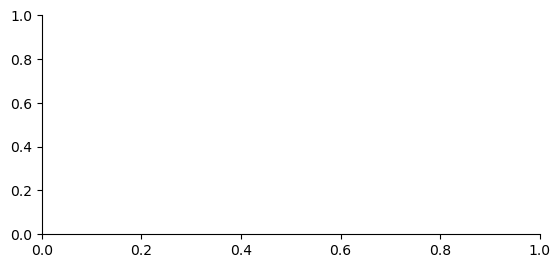

In [13]:
import matplotlib.pyplot as plt

labels = ['Ground Truth', 'Common Practice', 'Encore']
cMap = {
    'ground_truth': 'SeaGreen',
    'common_practice': 'IndianRed',
    'encore': 'CornFlowerBlue',
}

plt.figure(figsize=(6, 3))
plt.subplots_adjust(left=0.15, top=0.98, bottom=0.25, right=0.98)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, dir in enumerate(['ground_truth', 'common_practice', 'encore']):
    counts, bins = np.histogram(log_fcts[dir], bins=np.arange(np.min(log_fcts[dir]), np.max(log_fcts[dir]) + 0.1, 0.1))
    counts = np.cumsum(counts) / counts.sum()
    plt.plot(bins[:-1], counts, label=labels[i], color=cMap[dir], linewidth=2)

plt.legend(fontsize=18, frameon=False, loc=(0.4, -0.02))
plt.xlabel('log2(slowdown)', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.xticks(np.arange(7), fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linestyle='-.')

plt.savefig('figure/univ-performance.pdf', dpi=400)

In [14]:
cdfs = {}
for i, dir in enumerate(['ground_truth', 'common_practice', 'encore']):
    counts, bins = np.histogram(mean_fcts[dir], bins=np.arange(0, 40, 0.1))
    cdfs[dir] = np.cumsum(counts) / counts.sum()

cramer_dis = {}
cramer_dis['common_practice'] = np.sum(np.abs(cdfs['common_practice'] - cdfs['ground_truth']))
cramer_dis['encore'] = np.sum(np.abs(cdfs['encore'] - cdfs['ground_truth']))
cramer_dis['common_practice'] / cramer_dis['encore']

KeyError: 'ground_truth'